In [1]:
## ======= ##
## IMPORTS ##
## ======= ##

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import os
import dask
import dask.array
import math

import datetime

from collections import Counter

import pystac_client
from pystac.extensions.projection import ProjectionExtension as proj

import planetary_computer
import rasterio
import rasterio.features
from rasterio.features import rasterize

import stackstac
import pyproj

import dask.diagnostics

from shapely.geometry import box
from shapely.ops import transform

from scipy.ndimage import binary_propagation
from scipy.ndimage import label

import sat_tile_stack
from sat_tile_stack import sattile_stack as sts
from sat_tile_stack import sat_mask_array as sma



In [2]:
## ========= ##
## RUN BLOCK ##
## ========= ##

## CONNECT TO MICROSOFT PLANETARY COMPUTER
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,)
print(f"connected to Microsoft Planetary Computer")

# DECIDE WHETHER TO NORMALIZE THE IMAGERY UPON COMPLIING OR NOT
normalize = False

# BOUNDING BOX AROUND LAKE CENTROID
centroid = (-122.33, 37.81)
# centroid = (-122.45957, 37.80539) # CHRISSY FIELD MARSH
# centroid = (-49.495, 68.725) # NORTH LAKE

# SPECIFY TIME RANGE
time_range = '2019-08-01/2019-08-30'

# SPECIFY IMAGERY BANDS
band_names = ["B04",  # red (665 nm)
              "B03",  # green (560 nm)
              "B02",  # blue (490 nm)
              "B08",  # NIR (842 nm)
              "B11"]  # SWIR1 (1610 nm)

# CALL FUNCTION TO GENERATE TIMESTACK
filepath_geojson = "/home/jupyter/repos/sat-tile-stack/notebooks/oakland_port_terminals.geojson"
timestack = sts(catalog, centroid, band_names, pix_res=10, tile_size=256, time_range=time_range, normalize=True, mask=filepath_geojson, pull_to_mem=True)

# SAVE STACK TO DISK OR MAYBE NEED TO STACK THESE ALL TOGETHER ACROSS LAKES INTO ONE FILE???




connected to Microsoft Planetary Computer
epsg for bounds_latlon: 32610


/home/jupyter/repos/sat-tile-stack/src/sat_tile_stack/utils.py:9: RuntimeWarning: All-NaN slice encountered
  median_x = np.nanmedian(x)
/opt/conda/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1437: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/home/jupyter/repos/sat-tile-stack/src/sat_tile_stack/utils.py:12: RuntimeWarning: All-NaN slice encountered
  mn, mx = np.nanmin(robust), np.nanmax(robust)


pulling stack into memory, shape will be: (30, 6, 256, 256)
[#                                       ] | 4% Completed | 207.78 ms

/home/jupyter/repos/sat-tile-stack/src/sat_tile_stack/utils.py:9: RuntimeWarning: All-NaN slice encountered
  median_x = np.nanmedian(x)
/opt/conda/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1437: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/home/jupyter/repos/sat-tile-stack/src/sat_tile_stack/utils.py:12: RuntimeWarning: All-NaN slice encountered
  mn, mx = np.nanmin(robust), np.nanmax(robust)


[########################################] | 100% Completed | 1.86 sms
shape of stack in memory: (30, 6, 256, 256)


In [34]:
## ============================ ##
## DAILY CLOUD AND NAN TRACKING ##
## ============================ ##

df = pd.DataFrame({
    "eo_cloud_cover": timestack["eo_cloud_cover"].values,
    "pct_nans":      timestack.coords["pct_nans"].values
}, index=pd.to_datetime(timestack.time.values))

df


,eo_cloud_cover,pct_nans
2019-08-01,NaN,100.0
2019-08-02,NaN,100.0
2019-08-03,51.171966,0.0
2019-08-04,NaN,100.0
2019-08-05,NaN,100.0
2019-08-06,NaN,100.0
2019-08-07,NaN,100.0
2019-08-08,47.476429,0.0
2019-08-09,NaN,100.0
2019-08-10,NaN,100.0


/opt/conda/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1437: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


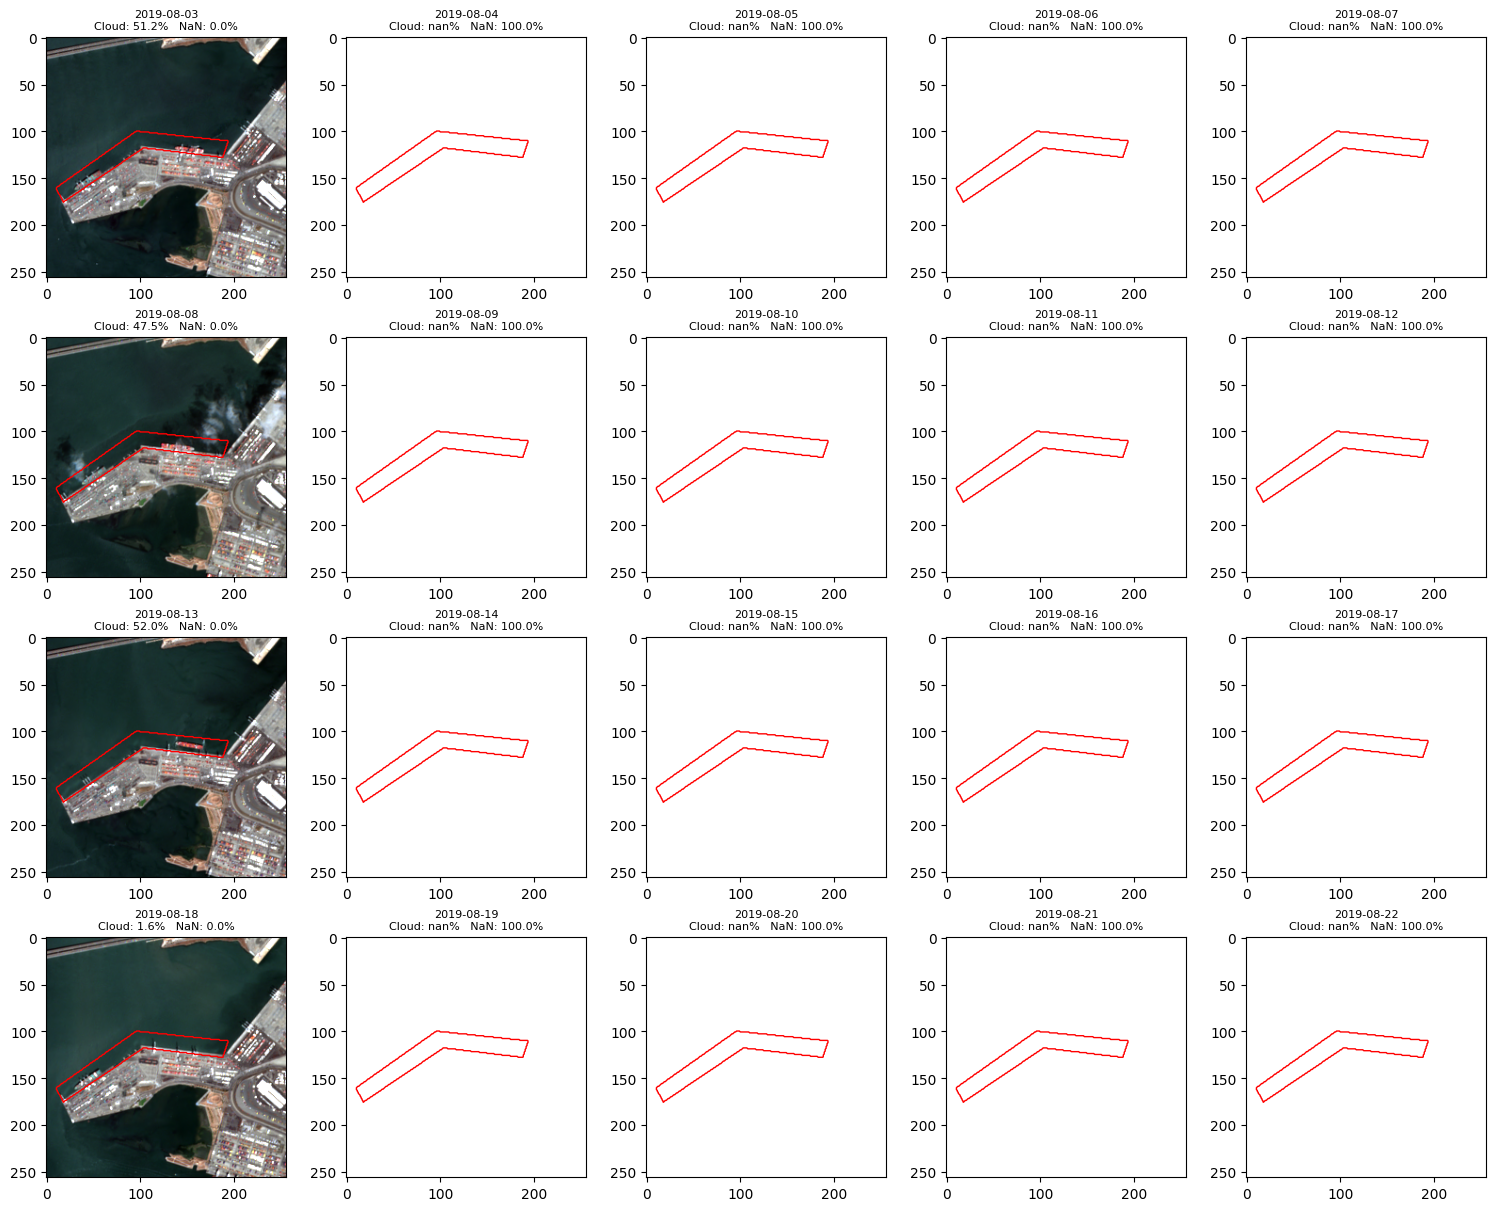

In [36]:
## ================== ##
## PLOTTING WITH MASK ##
## ================== ##

def linear_stretch_rgb(rgb, pmin=2, pmax=98):
    out = np.empty_like(rgb)
    for i in range(3):
        band = rgb[..., i]
        lo, hi = np.nanpercentile(band, (pmin, pmax))
        out[..., i] = np.clip((band - lo) / (hi - lo), 0, 1)
    return out

def plot_n_days(timestack, start_date, ndays=10, cols=4):
    """
    Plot consecutive daily RGB composites in subplots, 
    outlining the mask which is assumed to be the last band.

    Parameters
    ----------
    timestack : xarray.DataArray
        DataArray of shape (time, band, y, x), where band=-1 is the mask.
    start_date : str or np.datetime64
        The first date to plot, e.g. "2019-05-20".
    ndays : int
        Number of days to plot.
    cols : int
        Number of columns in the grid.
    """
    start = np.datetime64(start_date)
    rows = int(np.ceil(ndays / cols))
    fig, axes = plt.subplots(rows, cols, 
                             figsize=(cols*3, rows*3), 
                             constrained_layout=True)
    axes_flat = axes.flatten()

    for i in range(ndays):
        date = start + np.timedelta64(i, "D")
        tslice = timestack.sel(time=date)

        # build and stretch RGB from the *first* three bands
        r = tslice.isel(band=0).values
        g = tslice.isel(band=1).values
        b = tslice.isel(band=2).values
        rgb = np.stack([r, g, b], axis=-1)
        rgb_st = linear_stretch_rgb(rgb, pmin=0, pmax=98)

        ax = axes_flat[i]
        ax.imshow(rgb_st)

        # extract the mask (last band) and draw its 0.5 contour
        m2d = tslice.isel(band=-1).values
        ax.contour(m2d, levels=[0.5], colors="red", linewidths=1)

        # pull in the pct_nan and eo_cloud_cover
        pct_nan = float(tslice["pct_nans"].values)
        pct_cloud = float(tslice["eo_cloud_cover"].values)
        
        # add title
        title = (
            f"{str(date)[:10]}\n"
            f"Cloud: {pct_cloud:.1f}%   NaN: {pct_nan:.1f}%"
        )
        ax.set_title(title, fontsize=8)
        # ax.axis("off")

    # remove any empty subplots
    for j in range(ndays, rows*cols):
        fig.delaxes(axes_flat[j])

    plt.show()


plot_n_days(timestack, "2019-08-03", ndays=20, cols=5)


You'll notice that the percentage cloud doesn't necessarily correspond to the apparent cloudiness of the tile. This is because the cloud percentage is computed from the larger image strip from which this tile is extracted.
Nonetheless, we can use these percentages to help guider our model.  Perhaps we want the model to pay less attention to images that are more cloudy, or images that have above a certain threshold of NaN values.
This gives us the flexibility to do precisely this.